# General properties and calculations
For Argon propellant

In [27]:
# Base imports
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from CoolProp.CoolProp import PropsSI
from scipy import constants, optimize
from conversions import *
import powerThreshold as pt
from CEA import ThermoProps

# Custom packages
import IdealThrust as it
import saha

In [28]:
## Define and print some useful values
# R_UNIV = 8.31446261815324  # J mol^-1 K^-1, Universal gas constant
R_UNIV = constants.R

workingFluid = 'Argon'
standard_pressure = 101.3e3  # Pa, atmospheric pressure
standard_temperature = 273.15  # K, standard temperature (0C)
room_temperature = 290  # K, ambient temperature

gamma = PropsSI('isentropic_expansion_coefficient', 
    'P', standard_pressure, 
    'T', room_temperature, 
    workingFluid)
GAMMA = it.getGAMMA(gamma)
molarMass = PropsSI('M', workingFluid)

Rg = R_UNIV/molarMass

Km = it.mass_flow_constant(gamma, Rg)

print('gamma =', gamma)
print('GAMMA =', GAMMA)
print('M =', molarMass, 'kg/mol')
print('Rg =', Rg, 'J/kg-K')
print('Km =', Km, 'K^0.5-s/m')

gamma = 1.6685594298317419
GAMMA = 0.726455395772604
M = 0.039948 kg/mol
Rg = 208.13213722839694 J/kg-K
Km = 0.05035462684119578 K^0.5-s/m


In [29]:
## Define some inputs
min_pc = 3e5  # Pa
max_pc = 20e5  # Pa
chamber_pressures = np.linspace(min_pc, max_pc)

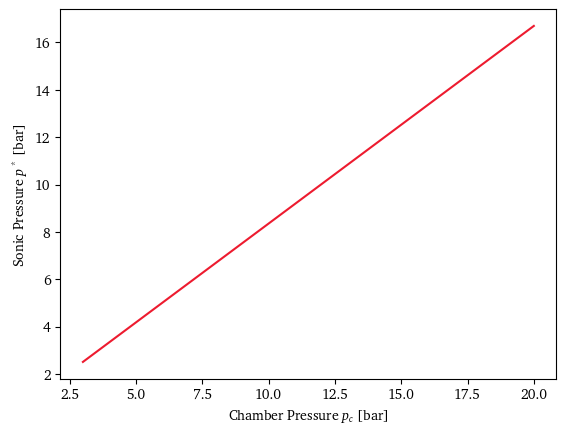

In [30]:
## Compute sonic conditions
sonic_pressures = chamber_pressures*(2/(gamma+1))**(gamma/(gamma+1))
plt.plot(chamber_pressures/1e5, sonic_pressures/1e5)
plt.xlabel('Chamber Pressure $p_c$ [bar]')
plt.ylabel(r'Sonic Pressure $p^*$ [bar]')
# convertAxis('x', (Pa2psi, psi2Pa), 'Chamber Pressure $p_c$ [psi]')
# convertAxis('y', (Pa2psi, psi2Pa), 'Sonic Pressure $p_c$ [psi]')
plt.show()

# Ideal Expansion
Most calculations will assume ideal expansion in the nozzle, i.e., matching pressure at the nozzle exit plane with no shocks, expansion fans, or flow separation. Given that the current design will always operate in ambient air, we can practically set the nozzle geometry to ensure ideal expansion. In such a case, the ideal thrust coefficent $C_F^\circ$ is the limit/target thrust coefficient, defined by:
$$
    C_F^\circ = \Gamma\sqrt{\frac{2\gamma}{\gamma-1}\left(1-\left(\frac{p_b}{p_0}\right)^{(\gamma-1)/\gamma}\right)}
$$

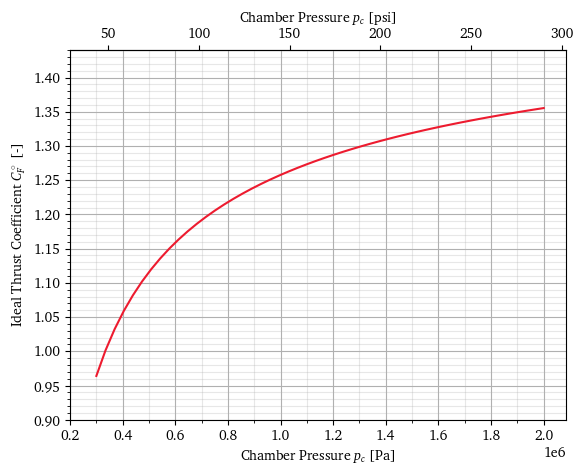

In [31]:
## Computing ideal expansion thrust factor
cf_ideal = it.cf_ideal(gamma, standard_pressure, chamber_pressures)

# Plotting
plt.plot(chamber_pressures, cf_ideal)
plt.xlabel('Chamber Pressure $p_c$ [Pa]')
plt.ylabel('Ideal Thrust Coefficient $C_F^\circ$ [-]')
plt.xticks(np.arange(min_pc-1e5, max_pc+1e5, 2e5))
plt.xticks(np.arange(min_pc, max_pc+1e5, 1e5), minor=True)
ylocs, ylab = plt.yticks()
ylocs_step = ylocs[1]-ylocs[0]
plt.yticks(np.arange(ylocs[0], ylocs[-1]+ylocs_step, ylocs_step))
plt.yticks(np.arange(ylocs[0], ylocs[-1]+ylocs_step, ylocs_step/5), minor=True)
plt.grid(which='major')
plt.grid(which='minor', alpha=0.3)
convertAxis('x', (Pa2psi, psi2Pa), 'Chamber Pressure $p_c$ [psi]')

plt.show()

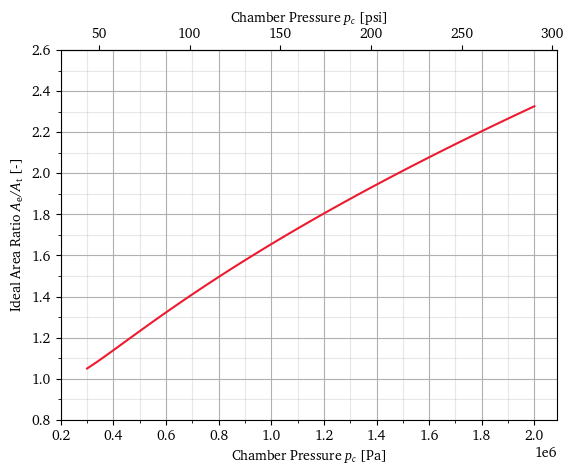

In [32]:
## Computing associated nozzle geometry
Aratio_ideal = it.Aratio_ideal(gamma, standard_pressure, chamber_pressures)

plt.plot(chamber_pressures, Aratio_ideal)
plt.xlabel('Chamber Pressure $p_c$ [Pa]')
plt.ylabel(r'Ideal Area Ratio $A_\mathrm{e}/A_\mathrm{t}$ [-]')
plt.xticks(np.arange(min_pc-1e5, max_pc+1e5, 2e5))
plt.xticks(np.arange(min_pc, max_pc+1e5, 1e5), minor=True)
ylocs, ylab = plt.yticks()
ylocs_step = ylocs[1]-ylocs[0]
plt.yticks(np.arange(ylocs[0], ylocs[-1]+ylocs_step, ylocs_step))
plt.yticks(np.arange(ylocs[0], ylocs[-1]+ylocs_step, ylocs_step/2), minor=True)
plt.grid(which='major')
plt.grid(which='minor', alpha=0.3)
convertAxis('x', (Pa2psi, psi2Pa), 'Chamber Pressure $p_c$ [psi]')

plt.show()

# Orifice Nozzle
In the case of a choked orifice nozzle, the thrust coefficient is as follows ($A_e/A_t = 1$):
$$
    C_F = C_F^\circ+\left(\frac{p_e}{p_c}-\frac{p_a}{p_c}\right)
$$
Where the exit pressure $p_e$ is equal to the sonic pressure $p^*$

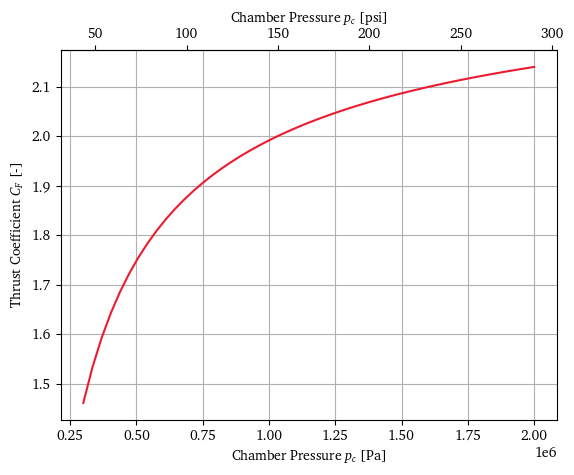

In [33]:
cf_orifice = cf_ideal+(sonic_pressures/chamber_pressures-standard_pressure/chamber_pressures)

plt.plot(chamber_pressures, cf_orifice)
plt.xlabel('Chamber Pressure $p_c$ [Pa]')
plt.ylabel(r'Thrust Coefficient $C_F$ [-]')
plt.grid()
convertAxis('x', (Pa2psi, psi2Pa), 'Chamber Pressure $p_c$ [psi]')


# Defining an operational range
To guide our design, we have to determine an operational range in terms of pressure, flow speed and input power. These will determine chamber and nozzle geometry. To begin, by assuming $C_F = C_F^\circ$, we can compute a throat area based on the desired chamber pressure and thrust of the engine:
$$
    C_F^\circ = C_F = \frac{F_\mathrm{T}}{p_0A_t} \implies A_t = \frac{F_\mathrm{T}}{p_0C_F^\circ}
$$

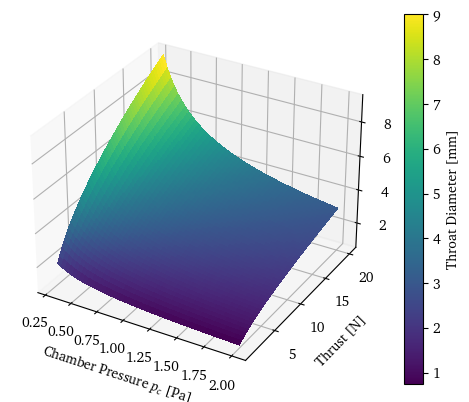

In [34]:
# Chamber pressure/thrust effect on throat diameter, assuming ideal exp
desired_thrust = np.linspace(1,20)  # N
CHAMBER_PRESSURES, THRUSTS = np.meshgrid(chamber_pressures, desired_thrust)
THROAT_AREA = (CHAMBER_PRESSURES 
               * it.cf_ideal(gamma, standard_pressure, CHAMBER_PRESSURES)
               / THRUSTS)**-1
THROAT_DIAMETER = np.sqrt(4*THROAT_AREA/np.pi)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(CHAMBER_PRESSURES, THRUSTS, THROAT_DIAMETER*1000,
                       cmap=matplotlib.cm.viridis, linewidth=0, 
                       antialiased=False)
ax.set_xlabel('Chamber Pressure $p_c$ [Pa]')
ax.set_ylabel('Thrust [N]')
fig.colorbar(surf, label='Throat Diameter [mm]')
plt.show()

Then we feed this to the choked mass flow rate equation:
$$
    \dot{m} = K_{\dot{m}}A_t\frac{p_0}{\sqrt{T_0}} = K_{\dot{m}}A_t\frac{p_0}{\sqrt{T(P_\mathrm{in}, \eta, \dot{m})}} = f(p_0, F_\mathrm{T}, P_\mathrm{in}, \eta, \dot{m})
$$
That's a lot of parameters... for starters, we can assume an energy conversion efficiency $\eta$ of around 50 %. Then, we can consider only the threshold power needed.

Zimakov et al. found that the threshold laser power $P_\mathrm{t}$ for LSP at 1.07 microns is related to the static pressure $p_0$ as follows:
$$
    P_\mathrm{t} = a\frac{1}{p_0^2}+b
$$
Where $a$ and $b$ are constants for a given gas. For Argon:
$$
    \begin{array}{ll}
        a_\mathrm{Ar} = 26\;\mathrm{bar}^2\,\mathrm{kW} \\
        b_\mathrm{Ar} = 0.24\;\mathrm{kW}
    \end{array}
$$
We thus have an expression for $P_\mathrm{in}$ as a function of $p_0$, reducing our mass flow formula to $\dot{m} = f(p_0, F_\mathrm{T})$

In [35]:
def bulk_temperature(power, efficiency, massflow, pressure=1e5):
    # The initial enthalpy appears to be 
    h0 = PropsSI('H', 'T', room_temperature, 'P', pressure.flatten(), workingFluid)
    newh = h0 + (efficiency*power.flatten())/massflow.flatten()
    return PropsSI('T', 'P', pressure.flatten(), 'H', newh, workingFluid)

def mass_flow_eq(m, At, p, efficiency):
    arrayShape = At.shape
    gas = pt.Gas[workingFluid]
    # if workingFluid.lower() != 'argon':
    #     raise ValueError('Invalid gas')
    POWER = pt.threshold_power(p, gas)
    TEMPERATURE = bulk_temperature(POWER, efficiency, m, p).reshape(arrayShape)
    return Km*At*p/np.sqrt(TEMPERATURE)

energy_conversion_efficiency = 1

# mdot = optimize.fixed_point(mass_flow_eq,
#                             np.ones(CHAMBER_PRESSURES.shape)*0.001,
#                             (THROAT_AREA, CHAMBER_PRESSURES, energy_conversion_efficiency))

# Closed form constant cp method: just need to solve a quadratic equation
constcp = PropsSI('C',
                  'T', room_temperature,
                  'P', CHAMBER_PRESSURES.flatten(),
                  workingFluid).reshape(THROAT_AREA.shape)
a = room_temperature
b = energy_conversion_efficiency*pt.threshold_power(CHAMBER_PRESSURES, pt.Gas[workingFluid].value)/constcp
c = -(Km*THROAT_AREA*CHAMBER_PRESSURES)**2
mdot_constcp = (-b+np.sqrt(b**2-4*a*c))/(2*a)
# rel_error = (mdot_constcp-mdot)/mdot
# plt.imshow(rel_error)
# plt.colorbar()
# plt.show()

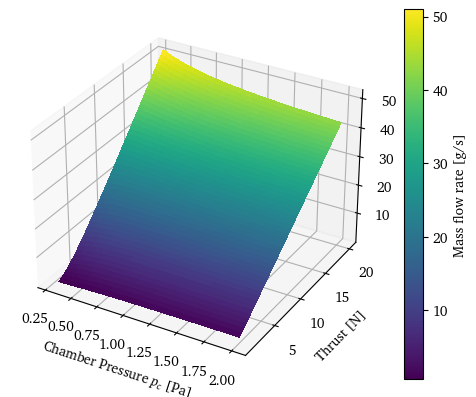

<Figure size 640x480 with 0 Axes>

In [36]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(CHAMBER_PRESSURES, THRUSTS, mdot_constcp*1000,
                       cmap=matplotlib.cm.viridis, linewidth=0, 
                       antialiased=False)
ax.set_xlabel('Chamber Pressure $p_c$ [Pa]')
ax.set_ylabel('Thrust [N]')
fig.colorbar(surf, label='Mass flow rate [g/s]')
plt.show()
plt.tight_layout()

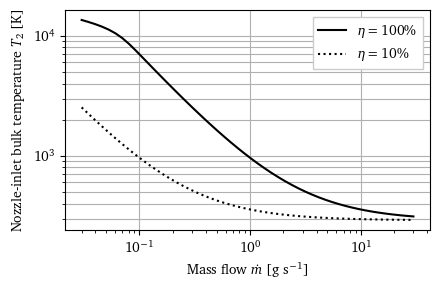

In [37]:
mdot = np.logspace(-5,-2)*3  # kg/s
# CoolProp approach
# h0_high = PropsSI('H', 'T', room_temperature, 'P', 10*1e5, workingFluid)
# h0_low = h0_high
# T0_high = PropsSI('T', 'P', 10*1e5, 'H', h0_high+(energy_conversion_efficiency*350)/mdot, workingFluid)
# T0_low = PropsSI('T', 'P', 10*1e5, 'H', h0_low+(0.1*350)/mdot, workingFluid)

# NASA CEA data
mdot = np.logspace(-5,-2)*3  # kg/s
qin = 350/mdot
fig, ax = plt.subplots(figsize=(4.5, 3))
for i, gas in enumerate(map(ThermoProps, [10])):
    hfromT_root = lambda T, h_target: gas.h(T)-h_target
    h0 = gas.h(room_temperature)
    T0_high_cea = []
    T0_low_cea = []
    fmt = 'C'+str(i)
    for q in qin:
        T0_high_cea.append(optimize.root_scalar(hfromT_root, args=h0+q, method='secant', 
            x0=1000, x1=2000).root)
        T0_low_cea.append(optimize.root_scalar(hfromT_root, args=h0+0.1*q, method='secant', 
            x0=1000, x1=2000).root)
    # ax.loglog(mdot*1000, T0_high_cea, fmt, label='{:.0f} bar'.format(gas.p/1e5))
    # ax.loglog(mdot*1000, T0_low_cea, fmt+':')
    ax.loglog(mdot*1000, T0_high_cea, 'k', label='$\eta =$100%')
    ax.loglog(mdot*1000, T0_low_cea, 'k:', label='$\eta =$10%')

# Constant cp conversion of propellant temperature to exhaust velocity
T_to_v = lambda T: np.sqrt((2*gamma)/(gamma-1)*Rg*T)
v_to_T = lambda v: (gamma-1)/(2*gamma*Rg)*v**2


# ax.loglog(mdot*1000, T0_high, 'k', label=r'$\eta =$100%')
# ax.loglog(mdot*1000, T0_low, 'k:', label=r'$\eta =$10%')

# secax = ax.secondary_yaxis('right', functions=(T_to_v, v_to_T))
# secax.set_ylabel('Exhaust velocity [m/s]')
plt.legend()
plt.grid(which='both', axis='y')
plt.grid(which='major', axis='x')
plt.xlabel(r'Mass flow $\dot{m}$ [g s$^{-1}$]')
plt.ylabel(r'Nozzle-inlet bulk temperature $T_2$ [K]')
plt.tight_layout()
# plt.savefig('../report/assets/4 models/heat_addition_flowing.pdf')
plt.show()

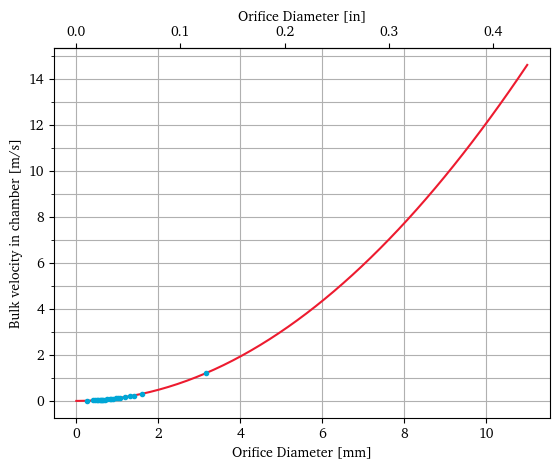

In [38]:
throat_diameters = np.linspace(0, 11)  # mm
orifices = np.array([0.01,  # Available orifice diameters on McMaster-Carr
            0.016,
            0.018,
            0.02,
            0.021,
            0.023,
            0.024,
            0.025,
            0.026,
            0.028,
            0.029,
            0.032,
            0.033,
            0.035,
            0.038,
            0.04,
            0.042,
            0.047,
            0.052,
            0.055,
            0.063,
            1/8 ])*25.4
def bulk_velocity(Km, Dt, D0, Rg, T0):
    return Km*(Dt/D0)**2*np.sqrt(T0)*Rg
fig, ax = plt.subplots()
plt.plot(throat_diameters, bulk_velocity(Km, throat_diameters, 38.1, Rg, 280))
plt.plot(orifices, bulk_velocity(Km, orifices, 38.1, Rg, 280),  '.')
plt.xlabel('Orifice Diameter [mm]')
plt.ylabel('Bulk velocity in chamber [m/s]')
plt.yticks(np.arange(1,16,2), minor=True)
plt.grid(which='both')
secax = ax.secondary_xaxis('top', functions=(lambda x_mm: x_mm/25.4, lambda x_in: x_in*25.4))
secax.set_xlabel('Orifice Diameter [in]')
plt.show()
